# Monster task model

In [1]:
from LOTlib3.Grammar import Grammar
from LOTlib3.DefaultGrammars import DNF
from math import log
from LOTlib3.Hypotheses.LOTHypothesis import LOTHypothesis
from LOTlib3.Hypotheses.Likelihoods.BinaryLikelihood import BinaryLikelihood
from LOTlib3.DataAndObjects import FunctionData, Obj
from LOTlib3.Eval import primitive
from collections import Counter

from LOTlib3 import break_ctrlc
from LOTlib3.Miscellaneous import qq
from LOTlib3.TopN import TopN
from LOTlib3.Samplers.MetropolisHastings import MetropolisHastingsSampler
import re, pyparsing as pp

import numpy as np
import matplotlib.pyplot as plt
from random import seed
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from LOTlib3.Eval import RecursionDepthException
from LOTlib3.Miscellaneous import Infinity

In [2]:
def rm_ticks(ax):
    ax.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)

# Generative grammar

### Definition

In [18]:
@primitive
def any_(F,S): 
    return any(map(F,S))


@primitive
def all_(F,S):
    return all(map(F,S))


@primitive
def fequal_(x, f, y):
    return getattr(x, f) == int(y)


@primitive
def fle_(x, f, y):
    return getattr(x, (f)) <= int(y)


@primitive
def fge_(x, f, y):
    return getattr(x, (f)) >= int(y)


# @primitive
# def fi_(x, y):
#     return getattr(x, (f)) < int(y)


ndims = 2

# Define a grammar object
# Syntax: `grammar.add_rule(NONTERMINAL, FUNCTION, ARGUMENTS, PROBABILITY)`
grammar = Grammar(start='START')

grammar.add_rule('START', '', ['Q'], 1.0) # Quantifier

# # The following lines are crucial for "recognizing OBJECTS provided in the data"
# grammar.add_rule('Q', 'forall_', ['FUNCTION', 'SET'], 1.0)
# grammar.add_rule('Q', 'exists_', ['FUNCTION', 'SET'], 1.0)
# grammar.add_rule('SET', 'S', None, 1.0)
# grammar.add_rule('FUNCTION', 'lambda', ['DISJ'], 1.0, bv_type='X')

# # Logical operations
# grammar.add_rule('DISJ', 'or_', ['CONJ', 'DISJ'], 1.0)
# # grammar.add_rule('DISJ', 'False', None, 1.0)
# grammar.add_rule('CONJ', 'and_', ['CONJ', 'P'], 1.0)
# # grammar.add_rule('CONJ', 'True', None, 1.0)

# The following lines are crucial for "recognizing OBJECTS provided in the data"
grammar.add_rule('Q', 'all_', ['FUNCTION', 'SET'], 1.0)
grammar.add_rule('SET', 'S', None, 1.0)
grammar.add_rule('FUNCTION', 'lambda', ['BOOL'], 1.0, bv_type='X')

# Logical operations
grammar.add_rule('BOOL', 'or_', ['BOOL', 'BOOL'], 1.0)
grammar.add_rule('BOOL', 'and_', ['BOOL', 'BOOL'], 1.0)

# Predicate becomes feature predicate
# grammar.add_rule('P', '', ['FP'], 1.0)


for v in range(1, 7):
    grammar.add_rule('BOOL', 'fequal_', ['X', 'F', str(v)], 1.0)
    grammar.add_rule('BOOL', 'fle_', ['X', 'F', str(v)], 1.0)
    grammar.add_rule('BOOL', 'fge_', ['X', 'F', str(v)], 1.0)

for i in range(ndims):
    grammar.add_rule('F', f'\'F{i}\'', None, 1.0)



### Simplicity bias

In [687]:
n = 10
print(f'{n} randomly generated productions from the grammar:\n')
print('| STRING LENGTH | SURPRISAL |')
print('|---------------|-----------|')
for _ in range(n):
    t = grammar.generate()
    print(f'| {len(t):13d} | {-grammar.log_probability(t):9.3f} |')
    # print(t)
print('|           ... |       ... |')

10 randomly generated productions from the grammar:

| STRING LENGTH | SURPRISAL |
|---------------|-----------|
|             7 |     4.382 |
|             7 |     4.382 |
|             7 |     4.382 |
|             7 |     4.382 |
|             7 |     4.382 |
|             7 |     4.382 |
|            11 |    11.067 |
|             7 |     4.382 |
|             7 |     4.382 |
|             7 |     4.382 |
|           ... |       ... |


In [688]:
slen, surp = [], []
for _ in range(1000):
    t = grammar.generate()
    slen.append(len(qq(t)))
    surp.append(grammar.log_probability(t))

fig, = plt.figure()
plt.scatter(x=slen, y=surp, alpha=.3, color='k', s=3)
plt.xlabel('Complexity (string length)')
plt.ylabel(r'$\log \pi(h)$')

TypeError: cannot unpack non-iterable Figure object

<Figure size 640x480 with 0 Axes>

# Ground Truth and Data

{'1d1': [<{s(F0=1, F1=4)} -> True>, <{s(F0=2, F1=4)} -> True>, <{s(F0=3, F1=4)} -> True>, <{s(F0=4, F1=4)} -> False>, <{s(F0=5, F1=4)} -> False>, <{s(F0=6, F1=4)} -> False>], '2d1': [<{s(F0=1, F1=1)} -> True>, <{s(F0=1, F1=2)} -> True>, <{s(F0=1, F1=3)} -> True>, <{s(F0=1, F1=4)} -> True>, <{s(F0=1, F1=5)} -> True>, <{s(F0=1, F1=6)} -> True>, <{s(F0=2, F1=1)} -> True>, <{s(F0=2, F1=2)} -> True>, <{s(F0=2, F1=3)} -> True>, <{s(F0=2, F1=4)} -> True>, <{s(F0=2, F1=5)} -> True>, <{s(F0=2, F1=6)} -> True>, <{s(F0=3, F1=1)} -> True>, <{s(F0=3, F1=2)} -> True>, <{s(F0=3, F1=3)} -> True>, <{s(F0=3, F1=4)} -> True>, <{s(F0=3, F1=5)} -> True>, <{s(F0=3, F1=6)} -> True>, <{s(F0=4, F1=1)} -> False>, <{s(F0=4, F1=2)} -> False>, <{s(F0=4, F1=3)} -> False>, <{s(F0=4, F1=4)} -> False>, <{s(F0=4, F1=5)} -> False>, <{s(F0=4, F1=6)} -> False>, <{s(F0=5, F1=1)} -> False>, <{s(F0=5, F1=2)} -> False>, <{s(F0=5, F1=3)} -> False>, <{s(F0=5, F1=4)} -> False>, <{s(F0=5, F1=5)} -> False>, <{s(F0=5, F1=6)} -> Fal

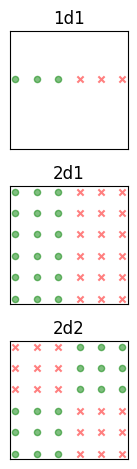

In [5]:
class Stimulus(object):
    def __init__(self, **kwargs):
        self.features = list(kwargs.keys())
        for k, v in kwargs.items():
            setattr(self, k, v)

    def __repr__(self):
        l = []
        for k, v in self.__dict__.items():
            if k!= 'features':
                l.append(f'{k}={v}')
        features_str = ', '.join(l)
        return f's({features_str})'
    

def gen_2d_stimuli1(F0_range, F1_range, rule):
    data = []
    pos_set = set()
    neg_set = set()
    for F0 in F0_range:
        for F1 in F1_range:
            stim = Stimulus(F0=F0, F1=F1)
            pos_set.add(stim) if eval(rule) else neg_set.add(stim)
                
    data.append(FunctionData(input=[pos_set], output=True, alpha=0.99))
    data.append(FunctionData(input=[neg_set], output=False, alpha=0.99))
    return data


def gen_2d_stimuli2(F0_range, F1_range, rule):
    data = []
    for F0 in F0_range:
        for F1 in F1_range:
            stim = Stimulus(F0=F0, F1=F1)
            data.append(FunctionData(input=[{stim}], output=eval(rule), alpha=0.99)) 
    return data


def grid_vis(data, ax, title):
    for subset in data:
        for stimulus in subset.input[-1]:
            c = 'g' if subset.output else 'r'
            m = 'o' if subset.output else 'x'
            ax.scatter(x = stimulus.__getattribute__('F0'), y = stimulus.__getattribute__('F1'), color=c, marker=m, s=20, alpha=.5)
            ax.set_title(title)
            ax.set_aspect('equal', 'box')


stim_defs = {
    '1d1': dict(rule = 'F0 <= 3', dims = [range(1, 7), range(4, 5)]),
    '2d1': dict(rule = 'F0 <= 3', dims = [range(1, 7), range(1, 7)]),
    '2d2': dict(rule = '(F0 <= 3 and F1 <= 3) or (F0 > 3 and F1 > 3)', dims = [range(1, 7), range(1, 7)]),
}

data = dict()
for k, d in stim_defs.items():
    data[k] = gen_2d_stimuli2(d['dims'][0], d['dims'][1], d['rule'])
print(data)

fig, axes = plt.subplots(nrows=3, ncols=1, sharey=True)
for i, (k, v) in enumerate(data.items()):
    grid_vis(v, axes[i], k)
    rm_ticks(axes[i])
fig.tight_layout()


stimuli = []
for F0 in range(1, 7):
    for F1 in range(1, 7):
        stimuli.append(Stimulus(F0=F0, F1=F1))

# F0, F1, cat, alpha = 2, 2, True, .9999
# obs = [FunctionData(input=[{Stimulus(F0=F0, F1=F1)}], output=cat, alpha=alpha) for i in range(1)]

# Inference

### Likelihood

We use `BinaryLikelihood` for our hypotheses:
```python
class BinaryLikelihood(object):
    def compute_single_likelihood(self, datum):
        try:
            return log(datum.alpha * (self(*datum.input) == datum.output) + (1.0-datum.alpha) / 2.0)
        except RecursionDepthException as e: # we get this from recursing too deep -- catch and thus treat "ret" as None
            return -Infinity
```

`self(*datum.input)` evaluates the input object in light of the hypothesis (`self`). If the hypothesis effectively evaluates an input to `True`, it means that according to this hypothesis, the input is a positive example of a category. Then, the expression `(self(*datum.input) == datum.output)` evaluates to `1` if the hypothesis is consistent with the observation, and `0` otherwise.

Thus, the likelihood given a single `datum` becomes equal to $\alpha[h(x_0,...,x_N)=y] + \frac{1-\alpha}{2}$, where $[h(x_0,...,x_N)=y]$ is an Iverson bracket. In other words, the likelihood is:
- $\alpha + \frac{1-\alpha}{2}$, when the hypothesis evaluates consistently with the observation
- $\frac{1-\alpha}{2}$, when it does not

The $\alpha$ parameter controls how strongly a given `datum` influences posterior belief in a hypothesis. If $\alpha$ is small, an observation will have similar likelihood regardless if whether it is consistent with the hypothesis or not. As the $\alpha$ parameter grows, inconsistent hypotheses become less likely in light of evidence, compared to consistent hypotheses. In practice, we use a log likelihood (see Fig. 1 below). The parameter $\alpha$ can thus be interpreted as a observation credibility parameter. A credibility of 1 tells us that we can use the `datum` to discard an inconsisten hypothesis and fully adopt the consistent one. A credibility of 0 tells us that posterior belief does not depend on the observation at all. Interestingly, we can also control the baseline probability decay for when $\alpha$ is equal to 0. That is, we can implement different assumptions about what happens to a hypothesis when the effects of observation fade away. For example, what happens to a hypothesis, when the memory of an observation decays? Presumably, that observation will no longer have any effect on the hypothesis in question, but will the hypothesis tend to regress towards the prior?

To help our intuition consider the following visualization.
|Fig 1. Likelihood|
|----------|
|<div><img src="img/likelihood_alt.png" width="500px"/></div>|
| <div style="width:500px">Here, we display the likelihood as a function of α (x-axis) and hypothesis accuracy (color, red vs blue), given a datum. Smaller values of α control the discrepancy between the likelihoods of consistent and inconsistent hypotheses. At the extreme, when α = 0, the likelihood is the same, regardless of the hypothesis. As α -> 1, the gap between likelihoods of consistent and inconsistent hypotheses increases. (To view alternative surprisal-based visualization, change the file name to likelihood_alt.png)</div>|

### Hypothesis `object`

In [20]:
class MyHypothesis(BinaryLikelihood, LOTHypothesis):
    def __init__(self, grammar=grammar, **kwargs):
        LOTHypothesis.__init__(self, grammar=grammar, display='lambda S: %s', **kwargs)

    def compute_single_likelihood(self, datum):
        try:
            return np.log(datum.alpha * (self(*datum.input) == datum.output) + (1.0-datum.alpha) / 2.0)
        except RecursionDepthException as e: # we get this from recursing too deep -- catch and thus treat "ret" as None
            return -Infinity
    
    def vis_mpl(self, stimuli, ax):
        for stimulus in stimuli:
            c = 'g' if self({stimulus}) else 'r'
            m = 'o' if self({stimulus}) else 'x'
            ax.scatter(x = stimulus.__getattribute__('F0'), y = stimulus.__getattribute__('F1'), color=c, marker=m, s=40, alpha=.5)
            ax.set_aspect('equal', 'box')


    def vis_text(self, stimuli, s=6):
        arr = np.zeros([s, s]).astype(bool)
        for stimulus in stimuli:
            if self({stimulus}):
                arr[stimulus.__getattribute__('F0') - 1, stimulus.__getattribute__('F1') - 1] = True
        
        for i, r in enumerate(np.flipud(arr.T)):
            print(f'{6-i} ' + '  '.join(['∆' if i else '•' for i in r]))
        print('  ' + '  '.join([str(i+1) for i in range(6)]))

### Updating a single hypothesis

In [21]:
# Sample a random hypothesis
seed(0)
h = MyHypothesis()
α = .9

print(f'Sampled hypothesis: {qq(h)}')
print('Predictions:')
h.vis_text(stimuli)
print()

consistent_stimulus = {Stimulus(F0=2, F1=5)}
inconsistent_stimulus = {Stimulus(F0=4, F1=0)}
print(f'h({consistent_stimulus}) = {h(consistent_stimulus)}')
print(f'h({inconsistent_stimulus}) = {h(inconsistent_stimulus)}', end='\n\n')

print(f'Prior surprisal is {-h.compute_prior():.3f}.', end=' ')
observed_stimulus = Stimulus(F0=2, F1=6)
obs = [[FunctionData(input=[{observed_stimulus}], output=True, alpha=α)], [FunctionData(input=[{observed_stimulus}], output=False, alpha=α)]]
loglik = [h.compute_likelihood(o) for o in obs]
post = [h.compute_posterior(o) for o in obs]
print(f'Given a positive stimulus ([{observed_stimulus}], and α={α}), we add {-loglik[0]:.3f} to the prior, so the posterior surprisal is {-post[0]:.3f}')
print(f'If the stimulus was negative, we would add {-loglik[1]:.3f} to the prior, and get a posterior of {-post[1]:.3f}.')


Sampled hypothesis: "lambda S: all_(lambda y2: fequal_(y2, 'F0', 2), S)"
Predictions:
6 •  ∆  •  •  •  •
5 •  ∆  •  •  •  •
4 •  ∆  •  •  •  •
3 •  ∆  •  •  •  •
2 •  ∆  •  •  •  •
1 •  ∆  •  •  •  •
  1  2  3  4  5  6

h({s(F0=2, F1=5)}) = True
h({s(F0=4, F1=0)}) = False

Prior surprisal is 3.689. Given a positive stimulus ([s(F0=2, F1=6)], and α=0.9), we add 0.051 to the prior, so the posterior surprisal is 3.740
If the stimulus was negative, we would add 2.996 to the prior, and get a posterior of 6.685.


### Updating a space of hypotheses

Entropies: prior = 1.6113586164374127; posterior = 0.7402977180943408


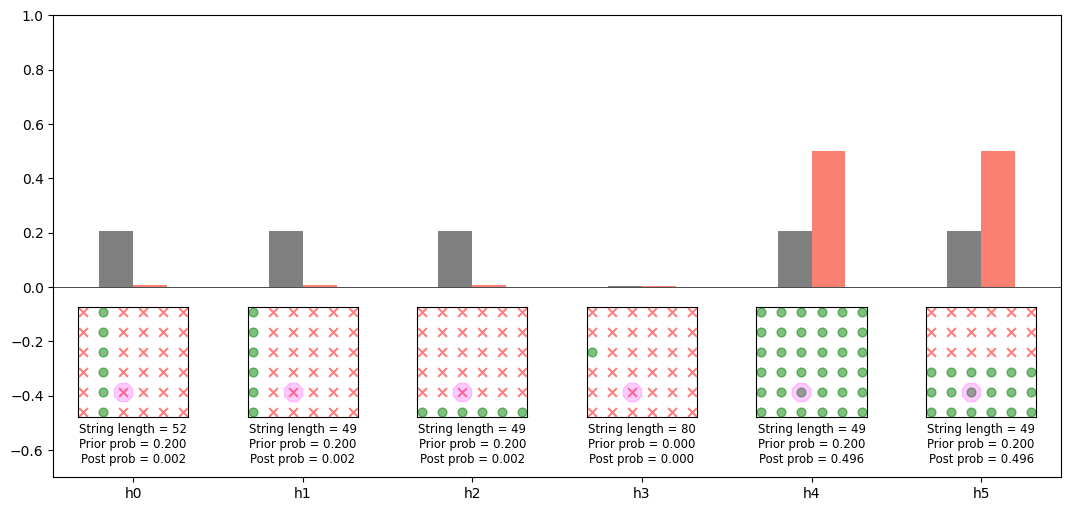

In [8]:
def dentropy(x):
    return -np.sum(x * np.log(x))

stim = Stimulus(F0=3, F1=2)
observation = [FunctionData(input=[{stim}], output=True, alpha=0.99)]

seeds = [1, 4, 27, 23, 99, 11]
hyps = []
for s in seeds:
    seed(s)
    hyps.append(MyHypothesis())


logprior, loglik, logpost = [], [], []
for i, h in enumerate(hyps):
    logprior.append(h.compute_prior())
    loglik.append(h.compute_likelihood(observation))
    logpost.append(h.compute_posterior(observation))

# Normalize
beliefs = [np.array(logprior), np.array(logpost)]
for i, b in enumerate(beliefs):
    b = np.exp(b)
    b = b/b.sum()
    beliefs[i] = b
fig.tight_layout()

print(f'Entropies: prior = {dentropy(beliefs[0])}; posterior = {dentropy(beliefs[1])}')
fig, ax = plt.subplots(figsize=[13, 6], nrows=1, ncols=1, sharex=True)

w, x = 0.20, np.arange(len(hyps))
ax.bar(x - w/2, beliefs[0]+.005, w, color='gray', label='prior')
ax.bar(x + w/2, beliefs[1]+.005, w, color='salmon', label='posterior')
ax.axhline(0, color='k', lw=.5)
ax.set_ylim([-.7, 1])
ax.set_xticks(x)
ax.set_xticklabels([f'h{i}' for i in x])
ax.grid
s = .65

for i, h in enumerate(hyps):
    axin = inset_axes(ax, width='100%', height='100%', bbox_transform=ax.transData, bbox_to_anchor=(x[i]-s/2, -.6, s, s), loc='upper center', borderpad=0)
    axin.set_aspect('equal')
    h.vis_mpl(stimuli, ax=axin)
    axin.scatter(x=stim.F0, y=stim.F1, marker='8', s=200, alpha=.2, color='magenta')
    rm_ticks(axin)
    axin.set_xlabel(f'String length = {len(qq(h))}\nPrior prob = {beliefs[0][i]:.3f}\nPost prob = {beliefs[1][i]:.3f}', fontsize='small')


# **MCMC**

In [33]:
h = MyHypothesis()

top  = TopN(N=100)
thin = 100
count = Counter()

for i, h in enumerate(MetropolisHastingsSampler(h, data['2d2'], steps=10_000)):
    count[h] += 1
    top << h
    if i % thin == 0:
        'nothing'

# for h in top.get_all(sorted=True):
#     print(h, h.posterior_score)
#     h.vis_text(stimuli)

	

# print the counts and the posteriors
for h in sorted(count.keys(), key=lambda x: count[x]):
	print(f'{count[h]:4d} {h.posterior_score:8.2f}', h)

   1   -99.15 lambda S: all_(lambda y2: fle_(y2, 'F1', 5), S)
   1   -99.15 lambda S: all_(lambda y2: fequal_(y2, 'F1', 5), S)
   1   -99.15 lambda S: all_(lambda y2: fge_(y2, 'F1', 2), S)
   1   -99.15 lambda S: all_(lambda y2: fge_(y2, 'F1', 1), S)
   1   -71.56 lambda S: all_(lambda y2: and_(or_(fle_(y2, 'F1', 3), fge_(y2, 'F0', 4)), or_(fle_(y2, 'F0', 6), fle_(y2, 'F0', 6))), S)
   1   -62.37 lambda S: all_(lambda y2: and_(or_(fle_(y2, 'F1', 3), fge_(y2, 'F0', 4)), or_(fge_(y2, 'F1', 4), and_(fequal_(y2, 'F0', 2), fle_(y2, 'F0', 3)))), S)
   2   -99.15 lambda S: all_(lambda y2: fequal_(y2, 'F0', 1), S)
   2   -99.15 lambda S: all_(lambda y2: fle_(y2, 'F1', 6), S)
   2   -99.15 lambda S: all_(lambda y2: fequal_(y2, 'F0', 4), S)
   2   -71.56 lambda S: all_(lambda y2: and_(or_(fle_(y2, 'F1', 3), fge_(y2, 'F0', 4)), or_(fle_(y2, 'F0', 6), fle_(y2, 'F1', 6))), S)
   2   -71.56 lambda S: all_(lambda y2: and_(or_(fle_(y2, 'F1', 3), fge_(y2, 'F0', 4)), or_(fequal_(y2, 'F0', 4), fge_(y2, '